## Model - YOLOv8
## type - All In One 
## Dataset - Extended
## Test - VisDrone (classwise)

# 1. Install Dependencies

In [1]:
!pip install torch torchvision
!pip install ultralytics

import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 745.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 6.3 MB/s eta 0:00:00


# 2. Dataset Preparation (Annotation)

as the format of annotation is as - object-class,x_center,y_center,width,height (all normalized as this is input format for YOLO5 prediction)

given annotation (in pixel) - bbox_left, bbox_top, bbox_width, bbox_height, score, object_category, truncation, occlusion

In [2]:
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image


os.makedirs('/kaggle/working/yolo_dataset/train', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/val', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/test', exist_ok=True)


os.makedirs('/kaggle/working/yolo_dataset/train/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/train/labels', exist_ok=True)

os.makedirs('/kaggle/working/yolo_dataset/val/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/val/labels', exist_ok=True)

os.makedirs('/kaggle/working/yolo_dataset/test/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/test/labels', exist_ok=True)

In [3]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


# Function to convert annotations
def convert_to_yolo_format(filename, annotations, img_width, img_height):
    with open(os.path.join(output_annotations_path, filename), 'w') as out_file:
        for annotation in annotations:
            if len(annotation) != 8:
                print(f"Error parsing annotation in {filename}: {annotation}")
                print(f"Ignoring malformed annotation: {annotation}")
                continue
            x_min, y_min, width, height, score, class_id, truncation, occlusion = map(float, annotation)
            if(class_id==0):
                continue
            # Convert to YOLO format
            center_x = x_min + (width / 2.0)
            center_y = y_min + (height / 2.0)
            center_x /= img_width
            center_y /= img_height
            width /= img_width
            height /= img_height
            class_id = class_id -1
            out_file.write(f"{int(class_id)} {center_x} {center_y} {width} {height}\n")

## for train + val (from extended)

In [4]:
# Paths to the dataset
annotations_path = '/kaggle/input/extended-dataset/Expanded_dataset/annotations'
images_path = '/kaggle/input/extended-dataset/Expanded_dataset/images'
output_annotations_path = '/kaggle/working/yolo_annotations'

# Ensure output directory exists
os.makedirs(output_annotations_path, exist_ok=True)


# Process all annotation files
for annotation_file in os.listdir(annotations_path):
    image_file = annotation_file.replace('.txt', '.jpg')
    image_path = os.path.join(images_path, image_file)
    
    if not os.path.exists(image_path):
        continue

    img_width, img_height = get_image_dimensions(image_path)
    
    with open(os.path.join(annotations_path, annotation_file), 'r') as file:
        lines = file.readlines()
        annotations = [line.strip().split(',') for line in lines]
        convert_to_yolo_format(annotation_file, annotations, img_width, img_height)
        


# Split the data
image_files = os.listdir(images_path)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Move files
for file in train_files:
    shutil.copy(os.path.join(images_path, file), '/kaggle/working/yolo_dataset/train/images/')
    shutil.copy(os.path.join(output_annotations_path, file.replace('.jpg', '.txt')), '/kaggle/working/yolo_dataset/train/labels/')

for file in val_files:
    shutil.copy(os.path.join(images_path, file), '/kaggle/working/yolo_dataset/val/images/')
    shutil.copy(os.path.join(output_annotations_path, file.replace('.jpg', '.txt')), '/kaggle/working/yolo_dataset/val/labels/')


## for test dataset (from VisDrone)

In [5]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images'
output_dataset_path = '/kaggle/working/yolo_dataset'
output_annotations_path = os.path.join(output_dataset_path, 'test/labels')
output_images_path = os.path.join(output_dataset_path, 'test/images')

os.makedirs(output_annotations_path, exist_ok=True)
os.makedirs(output_images_path, exist_ok=True)


# Process all annotation files
for annotation_file in os.listdir(annotations_path):
    image_file = annotation_file.replace('.txt', '.jpg')
    image_path = os.path.join(images_path, image_file)
    
    if not os.path.exists(image_path):
        continue

    img_width, img_height = get_image_dimensions(image_path)

    with open(os.path.join(annotations_path, annotation_file), 'r') as file:
        lines = file.readlines()
        annotations = [line.strip().split(',') for line in lines]
        convert_to_yolo_format(annotation_file, annotations, img_width, img_height)
        
        # Copy the image to the new dataset location
        output_image_path = os.path.join(output_images_path, image_file)
        if not os.path.exists(output_image_path):
            Image.open(image_path).save(output_image_path)


# 3. Create a Dataset Configuration File

In [6]:
data_config = """
train: /kaggle/working/yolo_dataset/train/images
val: /kaggle/working/yolo_dataset/val/images
test: /kaggle/working/yolo_dataset/test/images

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)



# Training Yolov8s

# epoch = 10

## Training on Extended  epoch=10 

In [7]:
import wandb
!export WANDB_MODE=disabled
wandb.init(mode="disabled")


from ultralytics import YOLO

# Load a YOLOv8 model
model = YOLO('/kaggle/working/yolov8n.pt')  # You can also use yolov8m.pt, yolov8l.pt, etc.

# Train the model
results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=10, imgsz=640, batch=16)


100%|██████████| 6.23M/6.23M [00:00<00:00, 77.3MB/s]


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/yolov8n.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

100%|██████████| 755k/755k [00:00<00:00, 15.0MB/s]
2024-06-27 09:02:43,290	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-27 09:02:44,866	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/working/yolo_dataset/train/labels... 1040 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:00<00:00, 1099.24it/s]

train: New cache created: /kaggle/working/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/val/labels... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<00:00, 885.18it/s]


val: New cache created: /kaggle/working/yolo_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       4.7G      1.408      3.356     0.9262        573        640: 100%|██████████| 65/65 [00:20<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]

                   all        261       9058     0.0259      0.272     0.0875     0.0602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.33G      1.032      1.808     0.8464        601        640: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

                   all        261       9058      0.446       0.16      0.148     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.47G     0.9362      1.339     0.8374        413        640: 100%|██████████| 65/65 [00:12<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

                   all        261       9058      0.492      0.282      0.262       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.35G     0.8844      1.081     0.8298        496        640: 100%|██████████| 65/65 [00:12<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]

                   all        261       9058      0.481       0.32      0.322      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.61G     0.8255     0.9607     0.8229        401        640: 100%|██████████| 65/65 [00:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]

                   all        261       9058      0.541      0.385      0.372      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.27G      0.793     0.8863     0.8153        625        640: 100%|██████████| 65/65 [00:12<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

                   all        261       9058      0.455      0.409      0.379      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.49G     0.7758     0.8425     0.8138        671        640: 100%|██████████| 65/65 [00:12<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.32it/s]

                   all        261       9058      0.441      0.435      0.403      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       4.5G     0.7567      0.817     0.8109        310        640: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        261       9058      0.541      0.422      0.418      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.74G     0.7305     0.7739     0.8096        460        640: 100%|██████████| 65/65 [00:12<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

                   all        261       9058      0.564      0.462      0.432      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.06G     0.7178     0.7498     0.8064        429        640: 100%|██████████| 65/65 [00:12<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        261       9058      0.484      0.451      0.438      0.325



10 epochs completed in 0.047 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:16<00:00,  1.83s/it]


                   all        261       9058      0.484      0.452      0.438      0.325
            pedestrian        175       2457       0.59      0.423      0.439      0.225
                people        115        810      0.526      0.298      0.289      0.144
               bicycle         45        124      0.316      0.161      0.154     0.0828
                   car        250       3396      0.853      0.884      0.911      0.742
                   van        182        707      0.797      0.863      0.884      0.713
                 truck        103        275      0.429      0.856      0.661      0.564
              tricycle         28         51      0.221     0.0392     0.0749     0.0547
       awning-tricycle         29         84      0.482      0.155      0.201      0.143
                   bus        126        336      0.558      0.857      0.761      0.677
                 motor        115        790      0.498      0.397        0.4      0.198
                other

## Val on extended  epoch=10 

In [8]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 1/17 [00:00<00:08,  1.89it/s]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:14<00:00,  1.13it/s]


                   all        261       9058      0.479      0.449      0.435      0.325
            pedestrian        175       2457      0.586      0.422      0.438      0.227
                people        115        810      0.531        0.3      0.291      0.146
               bicycle         45        124      0.322      0.161      0.154     0.0847
                   car        250       3396      0.849       0.88      0.909      0.745
                   van        182        707      0.793      0.859      0.876      0.712
                 truck        103        275      0.433      0.851      0.649      0.556
              tricycle         28         51      0.226     0.0392     0.0746     0.0551
       awning-tricycle         29         84      0.417      0.155        0.2      0.146
                   bus        126        336      0.557      0.845      0.754       0.67
                 motor        115        790      0.502      0.395        0.4        0.2
                other

## test on visdrone  epoch=10

In [9]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/yolo_dataset/test/labels... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:01<00:00, 957.07it/s] 

val: New cache created: /kaggle/working/yolo_dataset/test/labels.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:32<00:00,  3.11it/s]


                   all       1610      75367     0.0126     0.0665      0.011    0.00398
            pedestrian       1197      21006    0.00917     0.0291     0.0051     0.0014
                people        797       6376    0.00539     0.0287    0.00281   0.000733
               bicycle        377       1302   0.000892     0.0169   0.000493   0.000109
                   car       1530      28074     0.0791      0.184     0.0718     0.0255
                   van       1168       5771     0.0184     0.0839     0.0119    0.00437
                 truck        750       2659    0.00451     0.0534    0.00294    0.00121
              tricycle        245        530   0.000773     0.0208   0.000402   0.000139
       awning-tricycle        233        599    0.00219     0.0518    0.00151   0.000396
                   bus        838       2940      0.013      0.204     0.0216    0.00929
                 motor        794       5845    0.00403     0.0364    0.00213   0.000602
                other

# Epoch=25

In [10]:
import wandb
!export WANDB_MODE=disabled
wandb.init(mode="disabled")


from ultralytics import YOLO

# Load a model
model = YOLO("/kaggle/working/runs/detect/train/weights/last.pt")  # load a partially trained model

# # Load a YOLOv8 model
# model = YOLO('/kaggle/working/yolov8n.pt')  # You can also use yolov8m.pt, yolov8l.pt, etc.

# Train the model  # 10 prev + 15 new = 25
results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=15, imgsz=640, batch=16)




/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=15, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 1040 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      5.06G     0.7865     0.8177     0.8154        661        640: 100%|██████████| 65/65 [00:28<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

                   all        261       9058      0.432      0.465      0.431      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      4.31G     0.7766      0.757     0.8155        963        640: 100%|██████████| 65/65 [00:13<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261       9058      0.555      0.474      0.455      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      5.22G     0.7477     0.7294     0.8115        992        640: 100%|██████████| 65/65 [00:13<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        261       9058      0.498      0.472      0.474      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      4.42G     0.7443     0.7166     0.8108        581        640: 100%|██████████| 65/65 [00:13<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

                   all        261       9058      0.587      0.488      0.485       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      4.69G     0.7158     0.6748     0.8079       1150        640: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]

                   all        261       9058      0.609      0.493      0.523       0.38


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      4.76G     0.7241     0.7117     0.8056        702        640: 100%|██████████| 65/65 [00:22<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.25it/s]

                   all        261       9058      0.582      0.508      0.528      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15      4.41G     0.6957       0.66     0.8039        596        640: 100%|██████████| 65/65 [00:13<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        261       9058      0.515      0.509      0.517      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15      4.39G     0.7085     0.6618     0.8049        299        640: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.50it/s]

                   all        261       9058       0.59      0.552      0.559       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      4.36G     0.6826     0.6102     0.8008        468        640: 100%|██████████| 65/65 [00:13<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261       9058      0.628      0.557      0.576       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15      4.58G     0.6721     0.5874     0.7998        412        640: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]

                   all        261       9058       0.65      0.571       0.59      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15      4.06G      0.669     0.5727     0.7985        566        640: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        261       9058      0.691      0.556      0.602      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15      4.39G     0.6619     0.5643     0.7982        459        640: 100%|██████████| 65/65 [00:12<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        261       9058      0.651      0.583      0.608      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15      4.41G     0.6599     0.5547     0.7985        658        640: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

                   all        261       9058       0.73      0.547       0.61      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15      4.19G     0.6483     0.5432      0.797        537        640: 100%|██████████| 65/65 [00:12<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261       9058      0.705      0.569      0.616      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15      5.24G     0.6522     0.5414     0.7969        606        640: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]

                   all        261       9058      0.733      0.561      0.622      0.466



15 epochs completed in 0.078 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:17<00:00,  1.91s/it]


                   all        261       9058      0.732      0.562      0.622      0.466
            pedestrian        175       2457      0.751      0.423      0.523      0.292
                people        115        810      0.721       0.36      0.421      0.215
               bicycle         45        124      0.747      0.429      0.561      0.319
                   car        250       3396      0.933      0.887      0.931      0.779
                   van        182        707      0.916      0.884      0.931      0.758
                 truck        103        275      0.834      0.851      0.894      0.777
              tricycle         28         51      0.467      0.294      0.307      0.221
       awning-tricycle         29         84      0.825      0.562       0.62      0.459
                   bus        126        336       0.78      0.893      0.904      0.815
                 motor        115        790      0.713      0.416      0.535      0.291
                other

In [11]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')



Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:15<00:00,  1.12it/s]


                   all        261       9058      0.716      0.573      0.622      0.469
            pedestrian        175       2457      0.733      0.434      0.521      0.294
                people        115        810       0.71       0.37       0.43      0.219
               bicycle         45        124      0.726      0.448      0.561      0.327
                   car        250       3396      0.925      0.893      0.933      0.784
                   van        182        707      0.899      0.888      0.933      0.763
                 truck        103        275      0.818      0.847      0.898      0.787
              tricycle         28         51      0.471      0.294      0.313      0.232
       awning-tricycle         29         84      0.829      0.576      0.621      0.466
                   bus        126        336      0.778      0.895      0.904      0.815
                 motor        115        790      0.703      0.441       0.54      0.295
                other

In [12]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/yolo_dataset/test/labels.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:32<00:00,  3.12it/s]


                   all       1610      75367     0.0116     0.0636    0.00976    0.00349
            pedestrian       1197      21006    0.00803     0.0154    0.00495    0.00123
                people        797       6376    0.00481     0.0169    0.00249   0.000602
               bicycle        377       1302    0.00203     0.0169    0.00122   0.000252
                   car       1530      28074     0.0745      0.155     0.0595     0.0203
                   van       1168       5771     0.0114      0.078    0.00667    0.00239
                 truck        750       2659    0.00589     0.0429    0.00372    0.00145
              tricycle        245        530    0.00168     0.0792    0.00117   0.000426
       awning-tricycle        233        599    0.00227     0.0317     0.0014   0.000431
                   bus        838       2940     0.0142      0.222     0.0245     0.0108
                 motor        794       5845    0.00252     0.0193    0.00138   0.000369
                other

# Epoch = 50

In [13]:
import wandb
!export WANDB_MODE=disabled
wandb.init(mode="disabled")


from ultralytics import YOLO

# Load a model
model = YOLO("/kaggle/working/runs/detect/train/weights/last.pt")  # load a partially trained model

# # Load a YOLOv8 model
# model = YOLO('/kaggle/working/yolov8n.pt')  # You can also use yolov8m.pt, yolov8l.pt, etc.

# Train the model  # 25 prev + 25new = 50
results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=25, imgsz=640, batch=16)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 1040 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         5G     0.7865     0.8177     0.8154        661        640: 100%|██████████| 65/65 [00:28<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261       9058      0.432      0.465      0.431      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       4.3G     0.7765     0.7575     0.8156        963        640: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.23it/s]

                   all        261       9058      0.553      0.471      0.457      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      5.22G     0.7513     0.7308     0.8115        992        640: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        261       9058        0.5      0.482      0.476      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.42G     0.7463     0.7166     0.8111        581        640: 100%|██████████| 65/65 [00:13<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]

                   all        261       9058      0.555      0.483      0.487      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       4.7G     0.7169     0.6735     0.8084       1150        640: 100%|██████████| 65/65 [00:12<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]

                   all        261       9058      0.568      0.507      0.521      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.29G     0.7022     0.6507      0.807       1110        640: 100%|██████████| 65/65 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261       9058       0.59      0.525      0.532      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.76G     0.6983     0.6387     0.8056        749        640: 100%|██████████| 65/65 [00:13<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]

                   all        261       9058      0.639      0.525      0.554      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.87G     0.6972     0.6317     0.8047       1162        640: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261       9058       0.63      0.558      0.567      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.26G       0.69     0.6004     0.8053        894        640: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.49it/s]

                   all        261       9058      0.695      0.542      0.591      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.08G     0.6715     0.5869     0.8048        858        640: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        261       9058      0.631       0.56      0.583      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.14G     0.6572     0.5616     0.8025        714        640: 100%|██████████| 65/65 [00:13<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.53it/s]

                   all        261       9058      0.679      0.573      0.609      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      5.41G     0.6495     0.5681     0.8024        830        640: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        261       9058      0.658      0.589      0.616      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.26G     0.6454     0.5447     0.7979        809        640: 100%|██████████| 65/65 [00:13<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]

                   all        261       9058      0.689      0.593      0.623      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.87G     0.6294     0.5381     0.7991        970        640: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        261       9058      0.676        0.6      0.627      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.64G     0.6529     0.5311      0.801        950        640: 100%|██████████| 65/65 [00:13<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]

                   all        261       9058      0.731      0.581      0.626      0.462


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.75G     0.6624     0.5601      0.799        646        640: 100%|██████████| 65/65 [00:20<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.50it/s]

                   all        261       9058      0.698      0.585      0.622      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.42G     0.6354     0.5272      0.796        461        640: 100%|██████████| 65/65 [00:12<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

                   all        261       9058      0.695      0.573       0.62       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      3.68G     0.6494     0.5164     0.7951        434        640: 100%|██████████| 65/65 [00:12<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]

                   all        261       9058      0.741      0.579      0.634      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.42G     0.6328     0.4965     0.7928        483        640: 100%|██████████| 65/65 [00:12<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        261       9058      0.728      0.599      0.644      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.04G     0.6364     0.5018     0.7945        461        640: 100%|██████████| 65/65 [00:12<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]

                   all        261       9058      0.754      0.583      0.652      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      3.93G     0.6293      0.491     0.7924        552        640: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]

                   all        261       9058      0.736      0.595       0.65      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.84G     0.6153     0.4779     0.7942        412        640: 100%|██████████| 65/65 [00:12<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.42it/s]

                   all        261       9058      0.731      0.615      0.661      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.52G     0.6303     0.4764     0.7935        502        640: 100%|██████████| 65/65 [00:12<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]

                   all        261       9058      0.753        0.6      0.663      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.68G     0.6091     0.4672     0.7917        422        640: 100%|██████████| 65/65 [00:12<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.44it/s]

                   all        261       9058      0.775      0.585      0.661      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.85G     0.6077     0.4631     0.7916        537        640: 100%|██████████| 65/65 [00:12<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]

                   all        261       9058      0.756      0.597      0.662        0.5



25 epochs completed in 0.119 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:17<00:00,  1.90s/it]


                   all        261       9058      0.752        0.6      0.663      0.506
            pedestrian        175       2457      0.837      0.406      0.554      0.328
                people        115        810      0.789      0.362       0.47      0.241
               bicycle         45        124       0.82      0.514      0.619      0.391
                   car        250       3396      0.947      0.888      0.939      0.798
                   van        182        707      0.949      0.887      0.938      0.782
                 truck        103        275      0.856      0.858      0.916      0.802
              tricycle         28         51      0.424      0.333       0.35       0.26
       awning-tricycle         29         84      0.754      0.692      0.704       0.53
                   bus        126        336      0.818      0.914      0.922      0.845
                 motor        115        790      0.758      0.492      0.601      0.329
                other

In [14]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:15<00:00,  1.11it/s]


                   all        261       9058      0.737      0.609      0.663      0.508
            pedestrian        175       2457      0.825      0.426      0.559      0.332
                people        115        810      0.763      0.379      0.474      0.243
               bicycle         45        124      0.817      0.508      0.614      0.388
                   car        250       3396      0.939      0.893      0.939      0.805
                   van        182        707      0.943      0.895      0.943      0.785
                 truck        103        275      0.843      0.869      0.915      0.802
              tricycle         28         51      0.406      0.353      0.356      0.264
       awning-tricycle         29         84      0.716      0.702      0.698      0.533
                   bus        126        336      0.804      0.917      0.923      0.846
                 motor        115        790      0.728       0.51        0.6      0.332
                other

In [15]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/yolo_dataset/test/labels.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:32<00:00,  3.10it/s]


                   all       1610      75367     0.0104     0.0555    0.00839    0.00297
            pedestrian       1197      21006    0.00494    0.00876    0.00267   0.000663
                people        797       6376     0.0038     0.0127    0.00197   0.000463
               bicycle        377       1302   0.000863    0.00461   0.000454   0.000144
                   car       1530      28074     0.0726      0.147     0.0575       0.02
                   van       1168       5771    0.00846     0.0558    0.00475    0.00174
                 truck        750       2659    0.00516      0.032    0.00282    0.00106
              tricycle        245        530    0.00165     0.0792    0.00131   0.000396
       awning-tricycle        233        599    0.00161     0.0184    0.00101   0.000249
                   bus        838       2940     0.0126      0.218     0.0183    0.00755
                 motor        794       5845    0.00266     0.0231    0.00139   0.000368
                other

# Epoch = 100

In [16]:
import wandb
!export WANDB_MODE=disabled
wandb.init(mode="disabled")


from ultralytics import YOLO

# Load a model
model = YOLO("/kaggle/working/runs/detect/train/weights/last.pt")  # load a partially trained model

# # Load a YOLOv8 model
# model = YOLO('/kaggle/working/yolov8n.pt')  # You can also use yolov8m.pt, yolov8l.pt, etc.

# Train the model  # 50 prev + 50new = 100
results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=50, imgsz=640, batch=16)



/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 1040 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1040/1040 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      5.01G     0.7865     0.8177     0.8154        661        640: 100%|██████████| 65/65 [00:28<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        261       9058      0.432      0.465      0.431      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.32G     0.7763     0.7575     0.8156        963        640: 100%|██████████| 65/65 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

                   all        261       9058      0.554      0.469      0.457      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.23G     0.7527     0.7323     0.8118        992        640: 100%|██████████| 65/65 [00:13<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261       9058      0.487      0.481      0.473      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.43G     0.7483     0.7157     0.8112        581        640: 100%|██████████| 65/65 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]

                   all        261       9058      0.547      0.487      0.492      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.71G     0.7204     0.6753     0.8089       1150        640: 100%|██████████| 65/65 [00:13<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.90it/s]

                   all        261       9058       0.66      0.482      0.512      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       4.3G     0.7128     0.6622     0.8078       1110        640: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]

                   all        261       9058      0.597      0.534      0.543      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.78G     0.7004     0.6387     0.8058        749        640: 100%|██████████| 65/65 [00:13<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]

                   all        261       9058      0.642      0.523      0.551      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.88G     0.7028     0.6363     0.8051       1162        640: 100%|██████████| 65/65 [00:13<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261       9058      0.641      0.535      0.562      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.28G     0.6955     0.6072     0.8058        894        640: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]

                   all        261       9058      0.696      0.527      0.589      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       5.1G     0.6747     0.5938     0.8054        858        640: 100%|██████████| 65/65 [00:13<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]

                   all        261       9058      0.638       0.56      0.581       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.16G     0.6654      0.566     0.8028        714        640: 100%|██████████| 65/65 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        261       9058      0.701      0.562      0.606      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.42G      0.658     0.5712     0.8026        830        640: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]

                   all        261       9058      0.654      0.587      0.616       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.27G     0.6488     0.5464     0.7986        809        640: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]

                   all        261       9058      0.716      0.586      0.633      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.88G     0.6384     0.5451     0.8002        970        640: 100%|██████████| 65/65 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.49it/s]

                   all        261       9058      0.715      0.581      0.633      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.66G     0.6581     0.5346     0.8019        950        640: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]

                   all        261       9058      0.737      0.567      0.627      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.24G     0.6389     0.5237        0.8        617        640: 100%|██████████| 65/65 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]

                   all        261       9058      0.701      0.601      0.638      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.49G     0.6365     0.5185     0.7986        926        640: 100%|██████████| 65/65 [00:13<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]

                   all        261       9058      0.736      0.576      0.625      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.79G      0.642     0.5123     0.7986        783        640: 100%|██████████| 65/65 [00:13<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]

                   all        261       9058      0.695      0.614      0.647      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.14G     0.6244     0.4953     0.7972        803        640: 100%|██████████| 65/65 [00:13<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.85it/s]

                   all        261       9058      0.719      0.608      0.654      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.9G     0.6361     0.5102     0.7983        928        640: 100%|██████████| 65/65 [00:13<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.50it/s]

                   all        261       9058       0.74      0.607      0.658      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.03G     0.6203     0.4875      0.797        982        640: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.20it/s]

                   all        261       9058      0.746      0.612      0.663      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.62G     0.6175     0.4941     0.7978        989        640: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]

                   all        261       9058      0.722      0.611      0.651      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.55G     0.6202     0.4889     0.7961       1074        640: 100%|██████████| 65/65 [00:13<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.38it/s]

                   all        261       9058      0.737      0.632       0.67      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       5.1G     0.5985     0.4781     0.7949       1252        640: 100%|██████████| 65/65 [00:13<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        261       9058      0.744      0.593      0.655      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.82G      0.621     0.4738     0.7943        845        640: 100%|██████████| 65/65 [00:13<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.52it/s]

                   all        261       9058      0.751      0.612      0.672      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.39G     0.6185     0.4674     0.7949        713        640: 100%|██████████| 65/65 [00:12<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]

                   all        261       9058      0.731      0.627      0.674      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.23G     0.5968      0.453      0.793        777        640: 100%|██████████| 65/65 [00:13<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]

                   all        261       9058      0.745      0.605      0.661      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       4.9G     0.5991     0.4527     0.7936        686        640: 100%|██████████| 65/65 [00:13<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.17it/s]

                   all        261       9058      0.757       0.62      0.685      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.99G     0.5936     0.4553     0.7933        703        640: 100%|██████████| 65/65 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.47it/s]

                   all        261       9058      0.749      0.625       0.68      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.03G     0.6048     0.4539     0.7957        909        640: 100%|██████████| 65/65 [00:13<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.09it/s]

                   all        261       9058      0.779      0.613      0.675      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.77G     0.5887     0.4477     0.7938        604        640: 100%|██████████| 65/65 [00:13<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]

                   all        261       9058      0.734      0.632      0.678      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.82G     0.5788      0.433     0.7935        997        640: 100%|██████████| 65/65 [00:13<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.33it/s]

                   all        261       9058      0.766      0.637      0.692      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.18G     0.5859     0.4384     0.7932       1440        640: 100%|██████████| 65/65 [00:13<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.36it/s]

                   all        261       9058      0.784      0.624      0.689      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.23G     0.5837     0.4269     0.7917        579        640: 100%|██████████| 65/65 [00:13<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.29it/s]

                   all        261       9058      0.789      0.614      0.688      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.46G     0.5904     0.4286      0.792        724        640: 100%|██████████| 65/65 [00:13<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.52it/s]

                   all        261       9058      0.778      0.637      0.691      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.06G     0.5762     0.4258     0.7917        789        640: 100%|██████████| 65/65 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.51it/s]

                   all        261       9058       0.79      0.627       0.69      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.41G      0.564     0.4189     0.7925        944        640: 100%|██████████| 65/65 [00:13<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.66it/s]

                   all        261       9058      0.741      0.646      0.691      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.62G     0.5842     0.4222     0.7917        735        640: 100%|██████████| 65/65 [00:13<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.61it/s]

                   all        261       9058      0.781      0.643      0.695       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.13G     0.5721     0.4191      0.792        796        640: 100%|██████████| 65/65 [00:13<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]

                   all        261       9058       0.77      0.634      0.693      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       4.3G      0.542     0.4021       0.79        820        640: 100%|██████████| 65/65 [00:13<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

                   all        261       9058      0.776      0.655      0.702      0.531


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.22G     0.5951     0.4303     0.7883        396        640: 100%|██████████| 65/65 [00:20<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.31it/s]

                   all        261       9058       0.75      0.658      0.698      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.41G      0.593     0.4179     0.7913        544        640: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.49it/s]

                   all        261       9058      0.764       0.64      0.696      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.08G     0.5798     0.4054       0.79        699        640: 100%|██████████| 65/65 [00:12<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]

                   all        261       9058      0.795      0.626      0.697      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.92G     0.5817     0.4039     0.7866        527        640: 100%|██████████| 65/65 [00:12<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]

                   all        261       9058      0.812      0.624      0.699      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.62G     0.5781     0.3972     0.7859        302        640: 100%|██████████| 65/65 [00:12<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]

                   all        261       9058      0.772      0.641      0.698      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.3G     0.5791     0.4058     0.7877        428        640: 100%|██████████| 65/65 [00:12<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261       9058      0.785      0.635      0.695      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.86G     0.5871     0.4001     0.7872        384        640: 100%|██████████| 65/65 [00:12<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]

                   all        261       9058      0.761      0.654      0.693      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.28G     0.5715      0.394     0.7863        413        640: 100%|██████████| 65/65 [00:12<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]

                   all        261       9058      0.771      0.646      0.696      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.14G     0.5702     0.3888     0.7864        433        640: 100%|██████████| 65/65 [00:12<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.68it/s]

                   all        261       9058      0.804       0.64      0.701      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.99G      0.567     0.3891     0.7871        343        640: 100%|██████████| 65/65 [00:12<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:01<00:00,  4.57it/s]

                   all        261       9058      0.801      0.644      0.701      0.542



50 epochs completed in 0.245 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.3MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:17<00:00,  1.96s/it]


                   all        261       9058      0.801      0.644      0.702      0.543
            pedestrian        175       2457      0.829      0.471      0.596      0.359
                people        115        810      0.819      0.413      0.524      0.282
               bicycle         45        124      0.821      0.554      0.657      0.407
                   car        250       3396      0.947      0.903      0.948      0.816
                   van        182        707      0.933      0.908      0.947      0.805
                 truck        103        275      0.878       0.92      0.948      0.844
              tricycle         28         51      0.565      0.357      0.405      0.306
       awning-tricycle         29         84      0.851      0.749      0.766      0.592
                   bus        126        336      0.865      0.918      0.938      0.872
                 motor        115        790      0.819      0.488      0.623      0.357
                other

In [17]:
val_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


                   all        261       9058      0.805      0.645      0.703      0.548
            pedestrian        175       2457      0.828      0.472      0.597      0.367
                people        115        810      0.823      0.413      0.529      0.285
               bicycle         45        124      0.821      0.556      0.659      0.413
                   car        250       3396      0.947      0.902      0.948      0.823
                   van        182        707      0.933      0.909      0.949      0.813
                 truck        103        275      0.884       0.92       0.95      0.849
              tricycle         28         51      0.581      0.354      0.404      0.302
       awning-tricycle         29         84      0.818      0.749      0.763      0.595
                   bus        126        336       0.86       0.92      0.938      0.874
                 motor        115        790      0.822       0.49      0.624      0.362
                other

In [18]:
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /kaggle/working/yolo_dataset/test/labels.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:32<00:00,  3.12it/s]


                   all       1610      75367     0.0252     0.0231     0.0104    0.00356
            pedestrian       1197      21006    0.00885      0.002    0.00261   0.000618
                people        797       6376     0.0045    0.00439    0.00292   0.000603
               bicycle        377       1302    0.00379    0.00154   0.000378   8.02e-05
                   car       1530      28074      0.162     0.0816     0.0609     0.0197
                   van       1168       5771     0.0134     0.0116    0.00491    0.00178
                 truck        750       2659     0.0137    0.00865    0.00461    0.00178
              tricycle        245        530    0.00998     0.0245    0.00289    0.00086
       awning-tricycle        233        599     0.0081    0.00501    0.00184   0.000505
                   bus        838       2940     0.0439      0.105       0.03     0.0126
                 motor        794       5845    0.00545    0.00513    0.00233   0.000518
                other

# 6.a. Make Predictions on Extended from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1.jpg: 448x640 13 pedestrians, 4 peoples, 6 cars, 2 vans, 1 bus, 1 motor, 76.8ms
Speed: 3.7ms preprocess, 76.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Predicted Annotations:
Class: 3, Confidence: 0.9890262484550476, BBox: (594, 626, 675, 700)
Class: 3, Confidence: 0.9782669544219971, BBox: (412, 436, 486, 509)
Class: 3, Confidence: 0.9758588075637817, BBox: (663, 594, 768, 685)
Class: 4, Confidence: 0.95938640832901, BBox: (497, 8, 522, 34)
Class: 3, Confidence: 0.9421486258506775, BBox: (340, 284, 387, 341)
Class: 3, Confidence: 0.8924617767333984, BBox: (467, 9, 493, 32)
Class: 3, Confidence: 0.8571674823760986, BBox: (575, 8, 598, 32)
Class: 4, Confidence: 0.8432711362838745, BBox: (406, 77, 438, 108)
Class: 8, Confidence: 0.842214047908783, BBox: (516, 221, 579, 342)
Class: 0, Confidence: 0.7745422720909119, BBox: (225, 414, 233, 428)
Class: 0, Confidence: 0.7597326636314392, BBox: (1060, 5

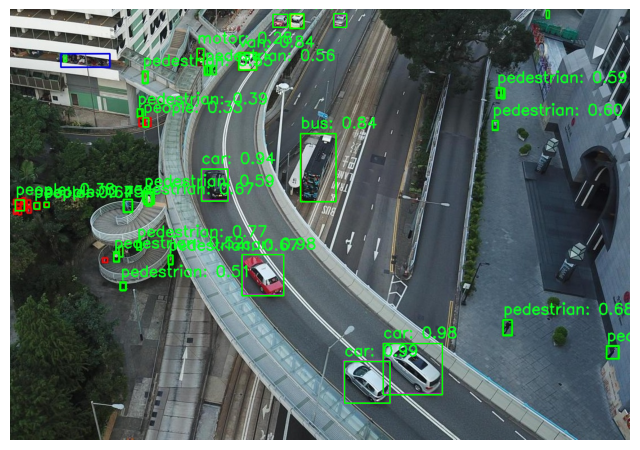


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1011.jpg: 352x640 17 pedestrians, 3 cars, 1 bus, 86.9ms
Speed: 2.0ms preprocess, 86.9ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)
Predicted Annotations:
Class: 3, Confidence: 0.9921017289161682, BBox: (657, 328, 711, 440)
Class: 3, Confidence: 0.9836527109146118, BBox: (138, 412, 206, 529)
Class: 3, Confidence: 0.9748513102531433, BBox: (216, 77, 274, 181)
Class: 8, Confidence: 0.8678576350212097, BBox: (219, 79, 355, 356)
Class: 0, Confidence: 0.7188107371330261, BBox: (454, 418, 467, 441)
Class: 0, Confidence: 0.6970682740211487, BBox: (1130, 13, 1148, 39)
Class: 0, Confidence: 0.6942281723022461, BBox: (1065, 36, 1085, 52)
Class: 0, Confidence: 0.6933780908584595, BBox: (1212, 456, 1231, 470)
Class: 0, Confidence: 0.6793467998504639, BBox: (1151, 5, 1167, 35)
Class: 0, Confidence: 0.6014435887336731, BBox: (1168, 14, 1187, 40)
Class: 0, Confidence: 0.5893688201904297, BBox: (14, 330, 43, 348)
Cl

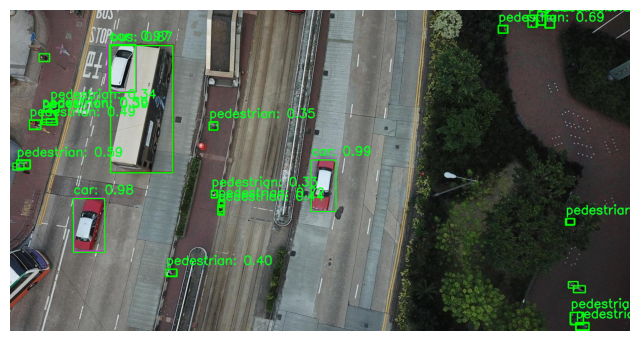


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/932.jpg: 352x640 4 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)
Predicted Annotations:
Class: 3, Confidence: 0.9587552547454834, BBox: (498, 520, 533, 591)
Class: 3, Confidence: 0.9503211975097656, BBox: (266, 127, 318, 161)
Class: 3, Confidence: 0.9499185085296631, BBox: (556, 131, 583, 174)
Class: 3, Confidence: 0.9442687630653381, BBox: (599, 58, 620, 102)


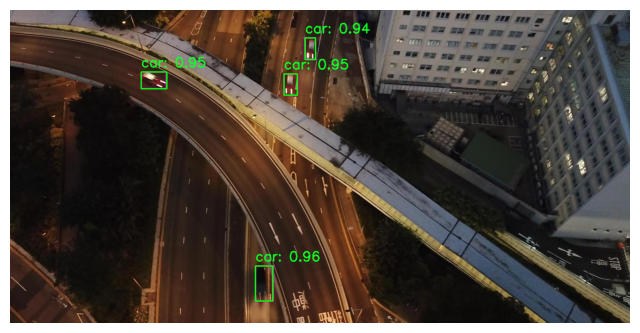


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/846.jpg: 352x640 10 pedestrians, 1 people, 24 cars, 1 van, 1 motor, 8.1ms
Speed: 2.4ms preprocess, 8.1ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)
Predicted Annotations:
Class: 3, Confidence: 0.9839848875999451, BBox: (846, 267, 896, 300)
Class: 3, Confidence: 0.9701215624809265, BBox: (618, 511, 795, 654)
Class: 3, Confidence: 0.965840756893158, BBox: (956, 206, 1005, 224)
Class: 3, Confidence: 0.9657897353172302, BBox: (558, 419, 687, 508)
Class: 3, Confidence: 0.946247398853302, BBox: (499, 236, 534, 270)
Class: 3, Confidence: 0.9449394941329956, BBox: (520, 312, 568, 367)
Class: 4, Confidence: 0.9441447257995605, BBox: (176, 294, 249, 347)
Class: 3, Confidence: 0.9314641952514648, BBox: (126, 283, 199, 322)
Class: 3, Confidence: 0.9168181419372559, BBox: (646, 324, 693, 368)
Class: 3, Confidence: 0.9115611910820007, BBox: (690, 268, 734, 301)
Class: 3, Confidence: 0.8959962129592896, BBox: (102

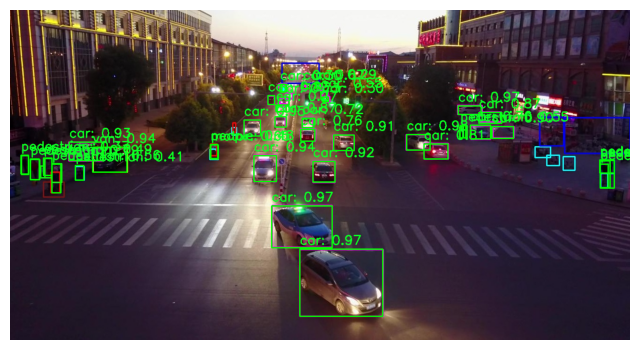


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/493.jpg: 320x640 7 cars, 1 van, 1 bus, 72.6ms
Speed: 1.9ms preprocess, 72.6ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Predicted Annotations:
Class: 3, Confidence: 0.9738359451293945, BBox: (428, 4, 449, 59)
Class: 4, Confidence: 0.9627024531364441, BBox: (813, 514, 858, 538)
Class: 3, Confidence: 0.9626896381378174, BBox: (473, 360, 497, 403)
Class: 3, Confidence: 0.9563530683517456, BBox: (613, 265, 648, 309)
Class: 3, Confidence: 0.9551382660865784, BBox: (439, 126, 459, 176)
Class: 3, Confidence: 0.9363155961036682, BBox: (516, 242, 536, 289)
Class: 3, Confidence: 0.9225748777389526, BBox: (375, 215, 393, 258)
Class: 3, Confidence: 0.883861243724823, BBox: (1161, 396, 1213, 415)
Class: 8, Confidence: 0.5734922885894775, BBox: (989, 519, 1108, 553)


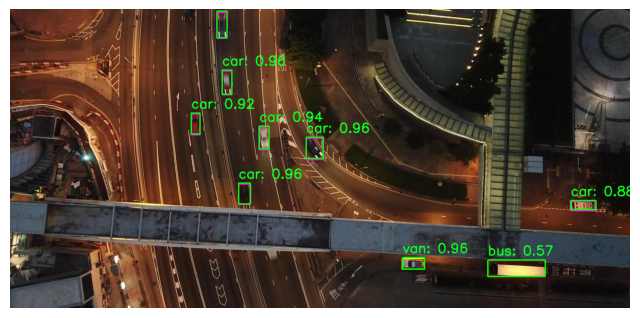

In [19]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = [1,1011,932,846,493]
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/extended-dataset/Expanded_dataset/images/'+ str(img_locat) + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 6.b. Make Predictions on visdrone from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.jpg: 384x640 1 car, 71.5ms
Speed: 2.0ms preprocess, 71.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Predicted Annotations:
Class: 3, Confidence: 0.38277167081832886, BBox: (659, 355, 748, 389)


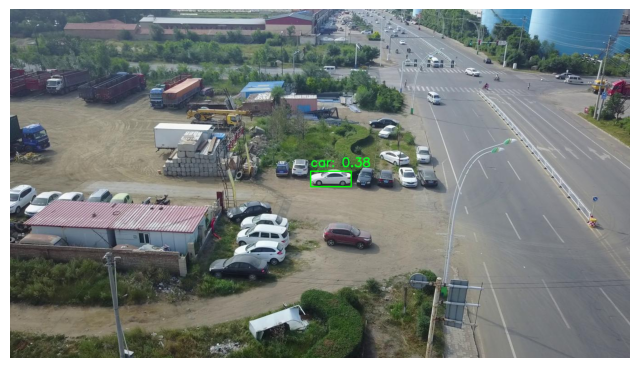


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000054_00786_d_0000001.jpg: 384x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)
Predicted Annotations:


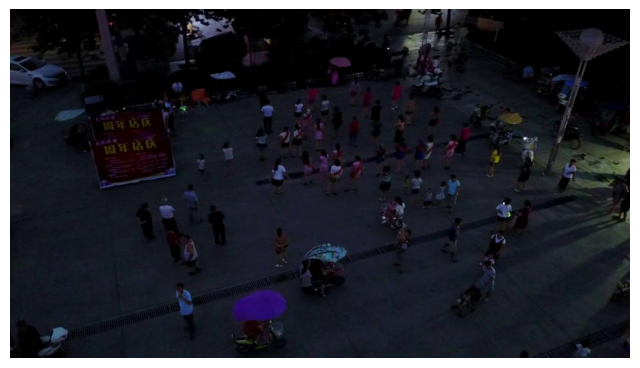

In [20]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = ['0000006_00159_d_0000001','0000054_00786_d_0000001']
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/'+ img_locat + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [21]:
# shutil.rmtree('/kaggle/working/yolo_dataset/val')

# Extra

In [22]:
data_config = """
train: /kaggle/working/yolo_dataset/train/images
val: /kaggle/working/yolo_dataset/test/images

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)

In [23]:
# Load the best model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluate the model on the new dataset
test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007793 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/yolo_dataset/test/labels.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [00:32<00:00,  3.10it/s]


                   all       1610      75367     0.0126     0.0665      0.011    0.00398
            pedestrian       1197      21006    0.00917     0.0291     0.0051     0.0014
                people        797       6376    0.00539     0.0287    0.00281   0.000733
               bicycle        377       1302   0.000892     0.0169   0.000493   0.000109
                   car       1530      28074     0.0791      0.184     0.0718     0.0255
                   van       1168       5771     0.0184     0.0839     0.0119    0.00437
                 truck        750       2659    0.00451     0.0534    0.00294    0.00121
              tricycle        245        530   0.000773     0.0208   0.000402   0.000139
       awning-tricycle        233        599    0.00219     0.0518    0.00151   0.000396
                   bus        838       2940      0.013      0.204     0.0216    0.00929
                 motor        794       5845    0.00403     0.0364    0.00213   0.000602
                other